In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Download dataset using kagglehub
print("Installing kagglehub...")
!pip install -q kagglehub

import kagglehub

print("\n Downloading Plants Classification dataset...")
path = kagglehub.dataset_download("marquis03/plants-classification")
print(f" Dataset downloaded at: {path}\n")

Installing kagglehub...



100%|██████████| 1.34G/1.34G [00:13<00:00, 106MB/s] 

Extracting files...


 Dataset downloaded at: /root/.cache/kagglehub/datasets/marquis03/plants-classification/versions/1



In [3]:
# Data Access
ROOT_DIR = path
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
VAL_DIR = os.path.join(ROOT_DIR, 'val')
TEST_DIR = os.path.join(ROOT_DIR, 'test')

print(f"Checking paths:")
print(f"Root: {ROOT_DIR}")
print(f"Train exists: {os.path.exists(TRAIN_DIR)}")
print(f"Val exists: {os.path.exists(VAL_DIR)}")
print(f"Test exists: {os.path.exists(TEST_DIR)}\n")

Checking paths:
Root: /root/.cache/kagglehub/datasets/marquis03/plants-classification/versions/1
Train exists: True
Val exists: True
Test exists: True



In [4]:
# Exploring the Dataset
def explore_dataset(root_dir):
    if not os.path.exists(root_dir):
        print(f"ERROR: {root_dir} does not exist!")
        return []

    classes = sorted(os.listdir(root_dir))
    classes = [c for c in classes if os.path.isdir(os.path.join(root_dir, c))]
    print(f"Number of classes: {len(classes)}")
    print(f"Classes: {classes[:5]}... (showing first 5)")

    total_images = 0
    for cls in classes:
        cls_path = os.path.join(root_dir, cls)
        num_images = len([f for f in os.listdir(cls_path) if f.endswith('.jpg')])
        total_images += num_images
    print(f"Total images: {total_images}")
    return classes

print("=== Train Set ===")
train_classes = explore_dataset(TRAIN_DIR)
print("\n=== Val Set ===")
val_classes = explore_dataset(VAL_DIR)
print("\n=== Test Set ===")
test_classes = explore_dataset(TEST_DIR)


=== Train Set ===
Number of classes: 30
Classes: ['aloevera', 'banana', 'bilimbi', 'cantaloupe', 'cassava']... (showing first 5)
Total images: 21000

=== Val Set ===
Number of classes: 30
Classes: ['aloevera', 'banana', 'bilimbi', 'cantaloupe', 'cassava']... (showing first 5)
Total images: 3000

=== Test Set ===
Number of classes: 30
Classes: ['aloevera', 'banana', 'bilimbi', 'cantaloupe', 'cassava']... (showing first 5)
Total images: 6000


In [5]:
class PlantsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.classes = [c for c in self.classes if os.path.isdir(os.path.join(root_dir, c))]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.images = []
        self.labels = []

        for cls in self.classes:
            cls_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_path):
                if img_name.endswith('.jpg'):
                    self.images.append(os.path.join(cls_path, img_name))
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

dataset_no_transform = PlantsDataset(TRAIN_DIR, transform=None)
print(f"\nDataset length: {len(dataset_no_transform)}")


Dataset length: 21000


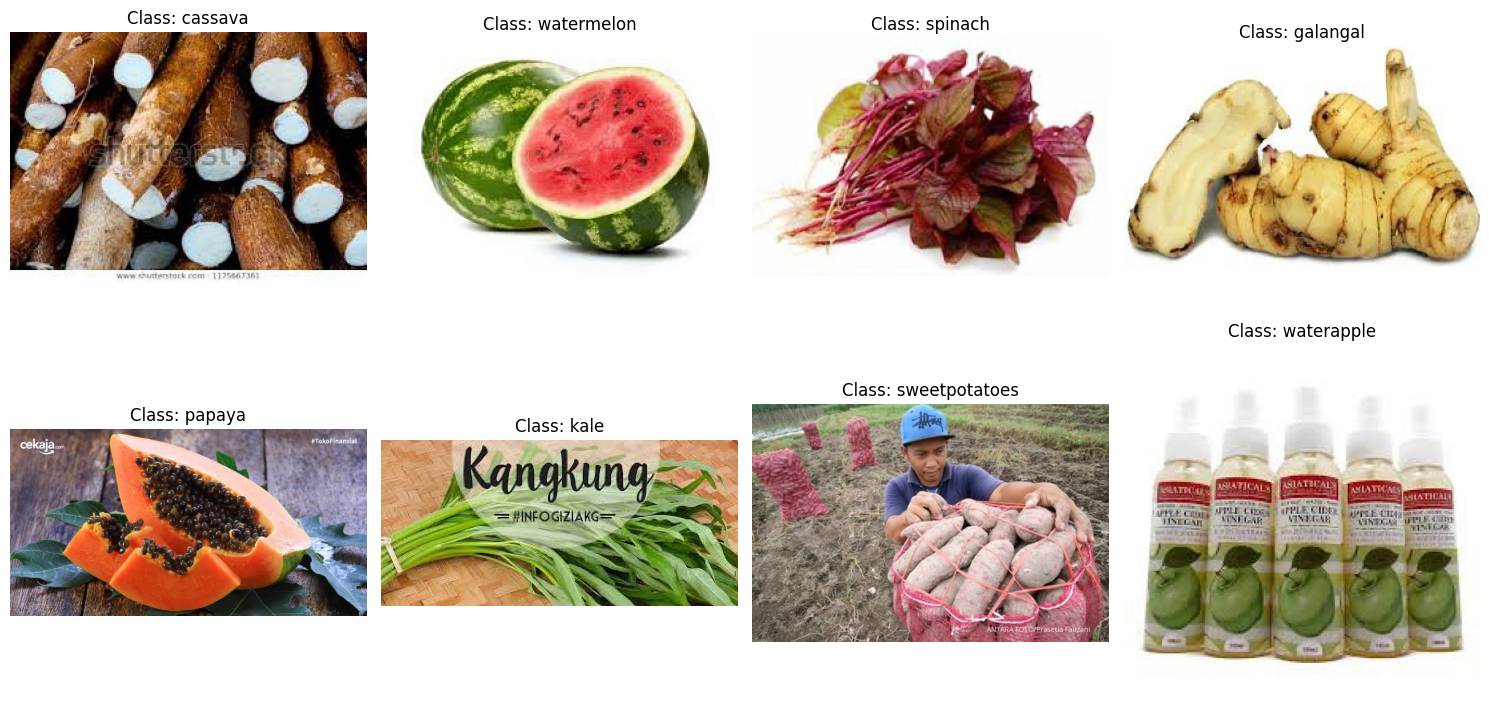

In [6]:
# Overview of the images in the dataset
def visualize_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.flatten()

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {dataset.classes[label]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(dataset_no_transform)

In [7]:
# Computing Mean and Standard Deviation
def compute_mean_std(dataset):
    preprocess = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    total_pixels = 0
    sum_pixels = torch.zeros(3)

    print("Computing Mean...")
    for img, _ in tqdm(dataset):
        img_tensor = preprocess(img)
        pixels = img_tensor.view(3, -1)
        sum_pixels += pixels.sum(dim=1)
        total_pixels += pixels.size(1)

    mean = sum_pixels / total_pixels

    sum_squared_diff = torch.zeros(3)

    print("Computing Std...")
    for img, _ in tqdm(dataset):
        img_tensor = preprocess(img)
        pixels = img_tensor.view(3, -1)
        diff = pixels - mean.unsqueeze(1)
        sum_squared_diff += (diff ** 2).sum(dim=1)

    std = torch.sqrt(sum_squared_diff / total_pixels)

    return mean, std

mean, std = compute_mean_std(dataset_no_transform)
print(f"\nMean: {mean}")
print(f"Std: {std}")


Computing Mean...


100%|██████████| 21000/21000 [01:30<00:00, 233.31it/s]


Computing Std...


100%|██████████| 21000/21000 [01:24<00:00, 247.28it/s]



Mean: tensor([0.6511, 0.6167, 0.4756])
Std: tensor([0.2929, 0.2870, 0.3412])


In [8]:
def get_transformations(mean, std):
    main_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    transform_with_augmentation = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    return main_transform, transform_with_augmentation

main_transform, augmentation_transform = get_transformations(mean, std)

In [26]:
print("Train Transform -with augmentation:")
print(augmentation_transform)

print("\nValidation/Test Transform:")
print(main_transform)


Train Transform -with augmentation:
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6511, 0.6167, 0.4756]), std=tensor([0.2929, 0.2870, 0.3412]))
)

Validation/Test Transform:
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6511, 0.6167, 0.4756]), std=tensor([0.2929, 0.2870, 0.3412]))
)


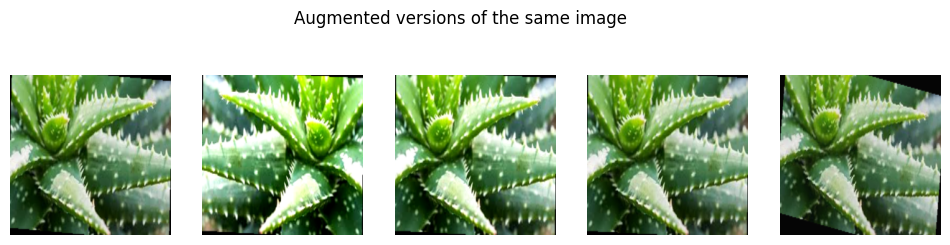

In [27]:
# Show Augmented Images
aug_dataset = PlantsDataset(TRAIN_DIR, transform=augmentation_transform)

plt.figure(figsize=(12, 3))
for i in range(5):
    img, _ = aug_dataset[0]
    img = img.permute(1, 2, 0).numpy()
    img = img * std.numpy() + mean.numpy()
    img = np.clip(img, 0, 1)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("Augmented versions of the same image")
plt.show()


In [9]:
# Data Loading
def get_dataloaders(train_dir, val_dir, test_dir, batch_size, main_transform, augmentation_transform):
    train_dataset = PlantsDataset(train_dir, transform=augmentation_transform)
    val_dataset = PlantsDataset(val_dir, transform=main_transform)
    test_dataset = PlantsDataset(test_dir, transform=main_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

BATCH_SIZE = 32
train_loader, val_loader, test_loader = get_dataloaders(
    TRAIN_DIR, VAL_DIR, TEST_DIR, BATCH_SIZE, main_transform, augmentation_transform
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 657
Val batches: 94
Test batches: 188


In [10]:
# Model Definition
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

model = models.mobilenet_v2(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 30)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Using device: cuda
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 129MB/s]


In [11]:
# Training and Validation
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

EPOCHS = 10
best_val_acc = 0.0

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Model saved! Best Val Acc: {best_val_acc:.2f}%")



Epoch 1/10


Validation: 100%|██████████| 94/94 [00:13<00:00,  6.85it/s]


Train Loss: 1.4408, Train Acc: 57.72%
Val Loss: 0.8691, Val Acc: 73.27%
Model saved! Best Val Acc: 73.27%

Epoch 2/10


Validation: 100%|██████████| 94/94 [00:13<00:00,  6.83it/s]


Train Loss: 1.0418, Train Acc: 68.42%
Val Loss: 0.8192, Val Acc: 75.30%
Model saved! Best Val Acc: 75.30%

Epoch 3/10


Validation: 100%|██████████| 94/94 [00:13<00:00,  6.79it/s]


Train Loss: 0.8886, Train Acc: 72.45%
Val Loss: 0.6944, Val Acc: 77.90%
Model saved! Best Val Acc: 77.90%

Epoch 4/10


Validation: 100%|██████████| 94/94 [00:13<00:00,  6.82it/s]


Train Loss: 0.7913, Train Acc: 75.32%
Val Loss: 0.6272, Val Acc: 80.60%
Model saved! Best Val Acc: 80.60%

Epoch 5/10


Validation: 100%|██████████| 94/94 [00:14<00:00,  6.65it/s]


Train Loss: 0.7317, Train Acc: 76.73%
Val Loss: 0.6817, Val Acc: 79.07%

Epoch 6/10


Validation: 100%|██████████| 94/94 [00:13<00:00,  6.80it/s]


Train Loss: 0.6677, Train Acc: 78.48%
Val Loss: 0.5266, Val Acc: 83.50%
Model saved! Best Val Acc: 83.50%

Epoch 7/10


Validation: 100%|██████████| 94/94 [00:13<00:00,  6.78it/s]


Train Loss: 0.6191, Train Acc: 79.57%
Val Loss: 0.5701, Val Acc: 82.50%

Epoch 8/10


Validation: 100%|██████████| 94/94 [00:13<00:00,  6.77it/s]


Train Loss: 0.5755, Train Acc: 80.93%
Val Loss: 0.5619, Val Acc: 83.37%

Epoch 9/10


Validation: 100%|██████████| 94/94 [00:14<00:00,  6.41it/s]


Train Loss: 0.5567, Train Acc: 81.69%
Val Loss: 0.6142, Val Acc: 81.80%

Epoch 10/10


Validation: 100%|██████████| 94/94 [00:13<00:00,  6.73it/s]


Train Loss: 0.5310, Train Acc: 82.00%
Val Loss: 0.4615, Val Acc: 84.10%
Model saved! Best Val Acc: 84.10%


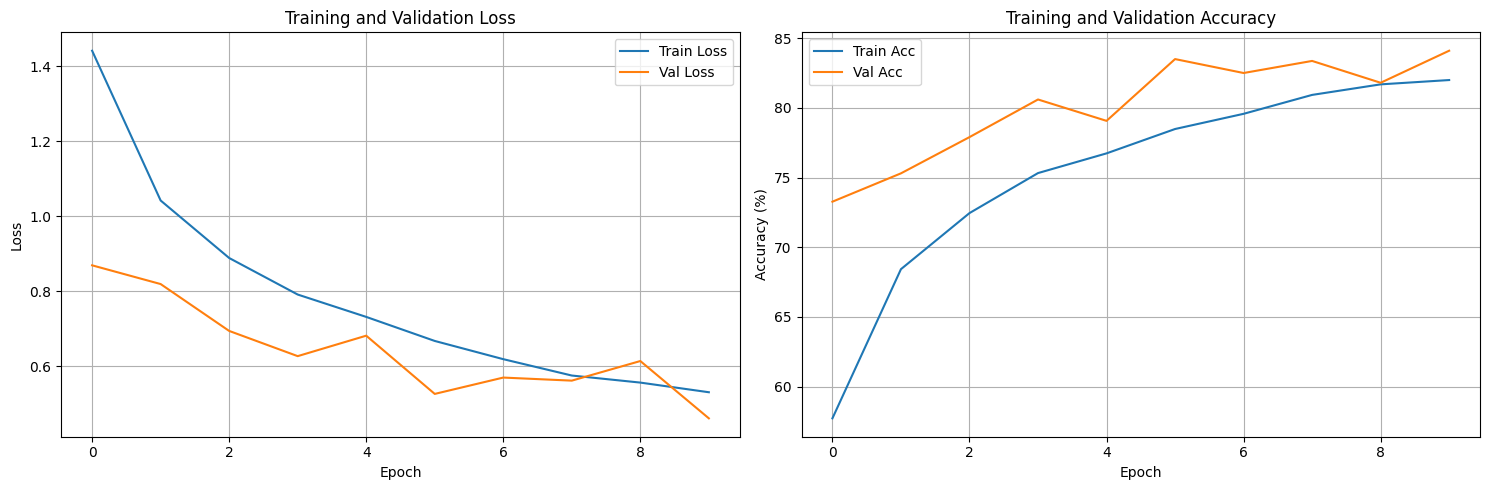

In [12]:
# Plot Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Acc')
ax2.plot(val_accs, label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [13]:
# Testing
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Validation: 100%|██████████| 188/188 [00:26<00:00,  7.03it/s]


Test Loss: 0.4601
Test Accuracy: 84.77%
